In [2]:
# Learn Fourier transform
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


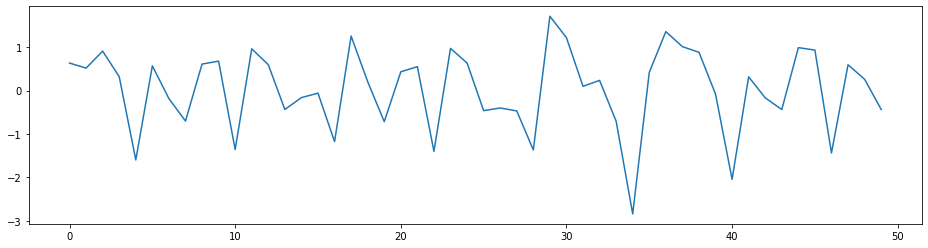

In [2]:
# Start by creating the data
# Wavelengths will be 2 - 9 to start
# Random example
plt.figure(figsize=(16,4))
wave = np.sum([np.random.random() * np.sin(2*np.pi/wavelength*(np.arange(0, 50, 1) - wavelength*np.random.random())) for wavelength in range(2,10)], axis=0)
plt.plot(wave)

In [3]:
minwave = 2 # a la Nyquist
nfreqs = 8 # Works with almost zero error, more frequencies not so much
def make_wave(wavelengths, amplitudes=None, phases=None, random_amplitudes=False, random_phases=False, duration=100, sin_and_cos=False):
    num_wavelengths = len(wavelengths)
    if amplitudes is None:
        if random_amplitudes:
            amplitudes = np.random.random(num_wavelengths)
        else:
            amplitudes = np.ones(num_wavelengths)/num_wavelengths
    if phases is None:
        if random_phases:
            phases = [wavelengths[i]*np.random.random() for i in range(num_wavelengths)]
        else:
            phases = np.zeros(num_wavelengths)
    wave = np.sum([amplitudes[i] * np.cos(2*np.pi/wavelengths[i]*(np.arange(0, duration) - phases[i])) for i in range(num_wavelengths)], axis=0)
    label = None
    if sin_and_cos:
        label = np.zeros((nfreqs, 2))
        for i in range(num_wavelengths):
            label[wavelengths[i]-minwave, 0] = amplitudes[i]*np.cos(2*np.pi*phases[i]/wavelengths[i])
            label[wavelengths[i]-minwave, 1] = amplitudes[i]*np.sin(2*np.pi*phases[i]/wavelengths[i])
    else:
        label = np.zeros(nfreqs)
        for i in range(num_wavelengths):
            label[wavelengths[i]-minwave] = amplitudes[i]
    return wave, label

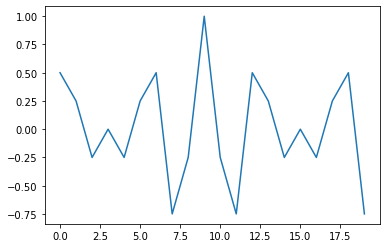

In [4]:
wave, label = make_wave([3,4], phases=[0,1], duration=20, sin_and_cos=True)
plt.plot(wave)

In [5]:
# How much information is required?
# The Fourier transform should be essentially linear.
# Adding two waves normally multiplies the Fourier transforms.
# In the case of pure waves, the delta functions add and multiply the same way, though.
def make_pure_training_data(samples=10, duration=100, shuffle=True, random_amplitudes=True, random_phases=False, totally_random=False, sin_and_cos=False):
    phase_factor = 8 if sin_and_cos else 1
    x_train = np.zeros((phase_factor*samples*nfreqs, duration))
    y_train = None
    if sin_and_cos:
        y_train = np.zeros((phase_factor*samples*nfreqs, nfreqs, 2))
    else: 
        y_train = np.zeros((phase_factor*samples*nfreqs, nfreqs))
    for f in range(minwave, minwave+nfreqs):
        for i in range(samples):
            if totally_random:
                wave, label = make_wave(np.arange(minwave,minwave+nfreqs), random_amplitudes=random_amplitudes, random_phases=random_phases, duration=duration, sin_and_cos=sin_and_cos)
            else:
                wave, label = make_wave([f], random_amplitudes=random_amplitudes, random_phases=random_phases, duration=duration, sin_and_cos=sin_and_cos)
            x_train[phase_factor*(samples*(f-2) + i)] = wave
            y_train[phase_factor*(samples*(f-2) + i)] = label
            if sin_and_cos:
                for j in range(1, phase_factor):
                    if totally_random:
                        wavep, labelp = make_wave(np.arange(minwave,minwave+nfreqs), random_amplitudes=random_amplitudes, random_phases=random_phases, duration=duration, sin_and_cos=sin_and_cos)
                    else:
                        wavep, labelp = make_wave([f], phases=[j*f/phase_factor], random_amplitudes=random_amplitudes, random_phases=random_phases, duration=duration, sin_and_cos=sin_and_cos)
                    x_train[phase_factor*(samples*(f-2) + i) + j] = wavep
                    y_train[phase_factor*(samples*(f-2) + i) + j] = labelp
    if shuffle:
        inds = np.arange(phase_factor*samples*nfreqs)
        np.random.shuffle(inds)
        x_train = x_train[inds]
        y_train = y_train[inds]
    return x_train.reshape(x_train.shape[0], x_train.shape[1], 1), y_train

In [6]:
duration = 64
# Only sin, random amplitude, fixed phase (does not fit well when there are multiple waves with different phases)
#x_train, y_train = make_pure_training_data(samples=1000, duration=duration, sin_and_cos=False, random_amplitudes=True, random_phases=False)
# Only sin, random amplitude, random phase (does not fit well at all)
#x_train, y_train = make_pure_training_data(samples=1000, duration=duration, sin_and_cos=False, random_amplitudes=True, random_phases=True)
# Sin and cos, random amplitudes and fixed phases (works great!)
#x_train, y_train = make_pure_training_data(samples=1000, duration=duration, sin_and_cos=True, random_amplitudes=True, random_phases=False)
# Totally random (surprisingly, still works perfectly!)
x_train, y_train = make_pure_training_data(samples=500, duration=duration, sin_and_cos=True, random_amplitudes=True, random_phases=True, totally_random=True)

In [7]:
model = Sequential()
# The regularizer seems to help a bit in the case when there are many frequencies, but not  that much.
#reg = keras.regularizers.l2(0.1)
model.add(Conv1D(2*nfreqs, duration, kernel_initializer='zeros', use_bias=False, input_shape=(duration, 1))) # sin and cos
#model.add(Conv1D(nfreqs, duration, kernel_initializer='zeros', use_bias=False, input_shape=(duration, 1))) # sin only
model.add(Reshape((nfreqs, 2))) # sin and cos
#model.add(Flatten()) # sin only
# SGD works better than Adam in this case -- The initial weights are near the optimal local minimum, but Adam can overshoot it.
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 16)             1024      
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 2)              0         
Total params: 1,024
Trainable params: 1,024
Non-trainable params: 0
_________________________________________________________________


Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 2s 91us/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2/3
25600/25600 [==============================] - 2s 75us/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 3/3
25600/25600 [==============================] - 2s 76us/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0105 - val_mse: 0.0105


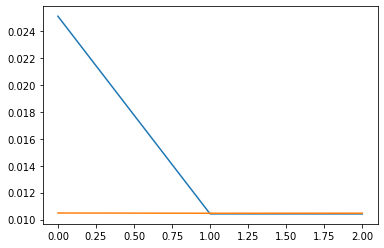

In [8]:
h = model.fit(x_train, y_train, validation_split=0.2, epochs=3) # This is all that is needed to train it fully.
plt.plot(h.history['mse'])
plt.plot(h.history['val_mse'])

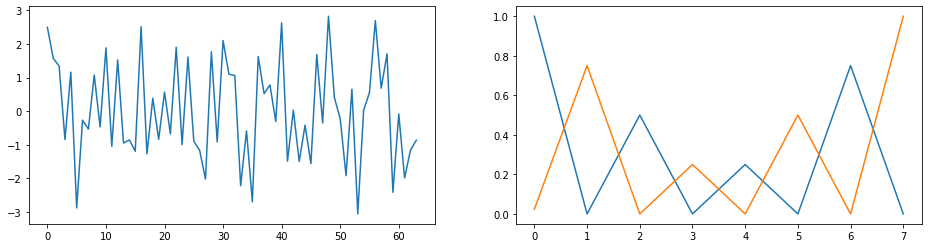

In [9]:
wave, label = make_wave([2,3,4,5,6,7,8,9], amplitudes=[1,0.75,0.5,0.25,0.25,0.5,0.75,1], phases=[0,3/4,0,5/4,0,7/4,0,9/4], duration=duration)
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].plot(wave)
axes[1].plot(model.predict(wave.reshape((1,duration,1)))[0])
# Honestly, it's pretty impressive that it can perfectly reconstruct the Frequency domain of such a noisy function.

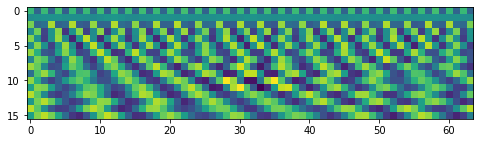

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(model.weights[0][:,0,:]))

In [11]:
np.max(model.weights[0][:,:,:])

0.043377098

In [1]:
# I think the constant error comes from the wave with maximum frequency but phased so that it ends up just being zero.
# Forgivable. Can't do much about the Nyquist frequency.
# Other than that, it seems to have nearly perfect accuracy.
# However, I can tell already that it wouldn't be able to understand a wave of lower frequency, because of how it was designed.
# I think I can decrease the length of the signal and still get good accuracy, though.
# I tried it as low as 18 and it still was decent. 50 seems plenty accurate.
# I'm just curious, does it learn this same pattern given fully random data?
# With just pure waves with random phases and amplitudes, it learns at nearly the same rate.
# Even with purely random mixtures of waves, as long as they are labeled well, it still fits perfectly.
# When it is expanded beyond 8 frequencies, it doesn't work quite as well for the longer wavelengths.

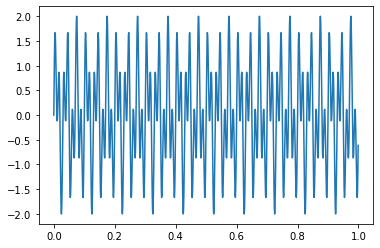

In [15]:
# On a different note, I want to explore the idea of using Fourier transforms for denoising.
# I can apply this to the bird audio dataset.
t = np.arange(0, 1, 0.001)
signal = np.sin(2*np.pi*30*t) + np.sin(2*np.pi*70*t)
plt.plot(t, signal)

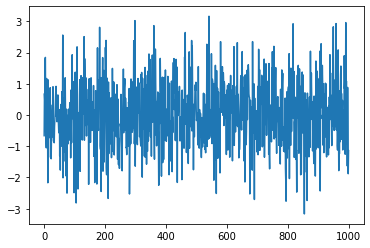

In [16]:
noise = np.random.randn(len(t))
plt.plot(noise)

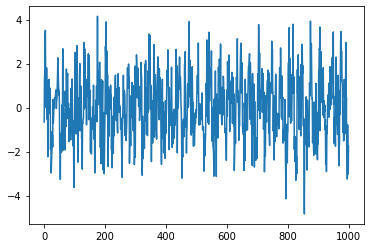

In [17]:
f = signal + noise
plt.plot(f)

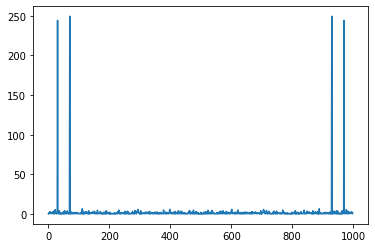

In [20]:
fhat = np.fft.fft(f, len(t))
power = fhat * np.conj(fhat) / len(t)
plt.plot(power)
# The two extra peaks are from folding above the Nyquist frequency, might as well cut off there.

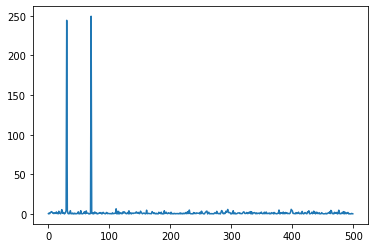

In [30]:
freq = (1/(0.001*len(t))) * np.arange(len(t)/2)
psd = power[0:len(freq)]
plt.plot(freq, psd)

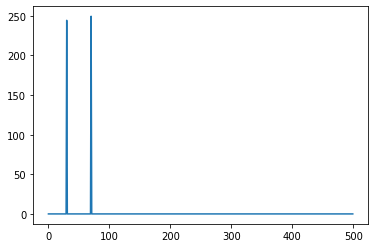

In [40]:
# Filter out the noise with an arbitrary cutoff
cutoff = np.max(power)*0.1 # 10% of max peak
filt = power > cutoff
# Show what the filtered power spectrum will look like
plt.plot((power * filt)[0:len(freq)])

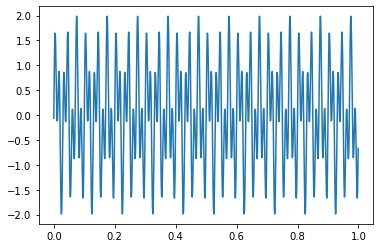

In [48]:
# Filter the complex coefficients
fhat = fhat * filt
# And take the inverse Fourier transform to get the filtered signal
ff = np.real(np.fft.ifft(fhat)) # Take the real part, even though the imaginary components are essentially all zero.
plt.plot(t, ff)

In [49]:
np.sum(signal - ff)

7.027711745877241e-13

In [158]:
# Analyze how well this works over a range of different noise and filter levels
# (Assuming all the frequencies in the signal have the same strength, which isn't really true in practice)
def get_filter_quality(freqs, noise_level, filter_level):
    t = np.arange(0, 1, 0.001)
    signal = np.zeros(len(t))
    for i in range(len(freqs)):
        signal += np.sin(2*np.pi*freqs[i]*t)
    noise = noise_level * np.random.randn(len(t))
    f = signal + noise
    fhat = np.fft.fft(f, len(t))
    power = fhat * np.conj(fhat) / len(t)
    cutoff = np.max(power) * filter_level
    filt = power > cutoff
    fhat = fhat * filt
    ff = np.real(np.fft.ifft(fhat))
    print(np.sum(np.abs(signal - ff))/len(t)) # Average difference between filtered signal and actual signal
    return power #np.abs(signal - ff)

0.10853235007119097


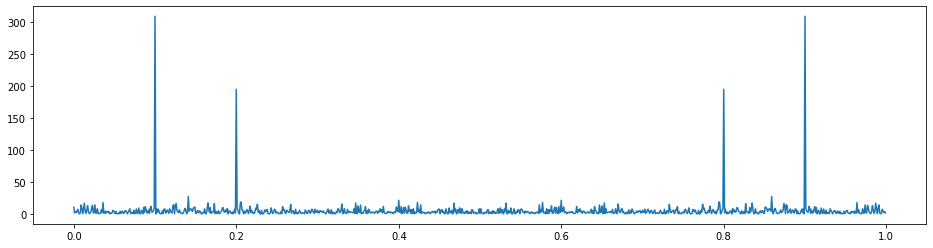

In [159]:
plt.figure(figsize=(16,4))
plt.plot(t, get_filter_quality([100, 200], 2.0, 0.25))
# The peaks in the power spectrum can vary significantly in amplitude due to addition of noise.